In [1]:
import sys
[sys.path.append(i) for i in ['.', '..']]
import torch
import numpy as np
# import sigpy as sp
# from sigpy.mri.app import L1WaveletRecon
from prox import Prox
from alg.eig import power_iter
from alg.cg import CG
from linear import LinearMap, FFTCn, NuSense, Sense, FFTCn, Identity, Diff2d
import matplotlib.pyplot as plt
import copy
import h5py
import torchkbnufft as tkbn

In [ ]:
# FFT example
device0 = torch.device('cuda:0')
from skimage.data import shepp_logan_phantom
I_shepp = torch.tensor(shepp_logan_phantom()).to(device0)
Fop = FFTCn((400, 400), (400, 400), (0,1), norm = 'ortho')
k_shepp = Fop*I_shepp

In [ ]:
plt.imshow(torch.log(torch.abs(k_shepp)).cpu().data.numpy())
plt.colorbar()

In [ ]:
# MRI parallel imaging example (SENSE)
ex_multi = np.load('AXT2_210_6001736_layer11.npz')
device0 = torch.device('cpu')
k_c = torch.tensor(ex_multi['k_r'] + 1j*ex_multi['k_i']).to(device0)/32767.0
s_c = torch.tensor(ex_multi['s_r'] + 1j*ex_multi['s_i']).to(device0)/32767.0
(nc, nh, nw) = s_c.shape
Fop = FFTCn((nc, nh, nw), (nc, nh, nw), (1,2), norm = 'ortho')
I1 = Fop.H*k_c
I1 = torch.sqrt(I1.abs().pow(2).sum(dim=0))
mask = torch.zeros(nh,nw)
mask[:,0:nw:8]=1
Sop = Sense((nh, nw), (nc, nh, nw), (0,1), s_c, mask, batchmode = False)
I0 = Sop.H*k_c
plt.figure(figsize=(20,10))
plt.imshow(torch.abs(I0).data.numpy())
plt.colorbar()

In [ ]:
T = Diff2d(Sop.size_in, dim = (0,1))
CG_tik = CG(Sop.H*Sop+0.02*T.H*T, max_iter = 20)

In [ ]:
I = Identity(Sop.size_in, Sop.size_in)
CG_tik = CG(Sop.H*Sop+0.02*I, max_iter = 20)

In [ ]:
I0.requires_grad_()

In [ ]:
I_tik = CG_tik.run(I0, I0)

In [ ]:
torch.sum(torch.pow(torch.abs(I_tik),2)).backward()

In [ ]:
I0.grad

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(torch.abs(I0.grad).cpu().data.numpy())
plt.colorbar()

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(torch.abs(I_tik).cpu().data.numpy())
plt.colorbar()

In [3]:
hf = h5py.File('./b0.h5', 'r')
nx = 320;
ny = 320;
ktraj = hf['ktraj'][()]
ktraj = np.remainder(ktraj + np.pi, 2*np.pi)-np.pi
# ktraj = np.transpose(ktraj)/np.pi*nx/2
print('traj shape', ktraj.shape)
k = hf['k_r'][()] + 1j*hf['k_i'][()]
[ncoil, nslice, nshot, ns] = k.shape
print('k shape', k.shape)
dcf = hf['dcf'][()]
print('dcf shape', dcf.shape)
ksp = k.reshape(ncoil,nslice,nshot*ns)
smap = np.transpose(hf['s_r'][()] + 1j*hf['s_i'][()], (3,0,1,2))
smap = np.transpose(smap, (0,1,3,2))
print('smap shape', smap.shape)
fmap = hf['b0'][()]
fmap = np.transpose(fmap, (0,2,1))
print('fmap shape', fmap.shape)
ktrajunder = ktraj.reshape(320,1280,2)
ktrajunder = ktrajunder[0:-1:5,:,:].reshape(81920,2)
kunder = k[:,:,0:-1:5,:]

traj shape (2, 409600)
k shape (32, 15, 320, 1280)
dcf shape (1, 409600)
smap shape (15, 32, 320, 320)
fmap shape (15, 320, 320)


In [4]:
im_size = (320,320)
iz = 6
k0 = torch.tensor(k[:,iz,:,:]).to(device = 'cuda:0').reshape(1,ncoil,nshot*ns)
s0 = torch.tensor(smap[iz,:,:,:]).to(device = 'cuda:0').unsqueeze(0)
ktraj = torch.tensor(ktraj).to(device = 'cuda:0')
# adjnufft_ob = tkbn.KbNufftAdjoint(im_size=im_size, grid_size=tuple(np.array(im_size)*2)).to(device = 'cuda:0')
Nop = NuSense(s0, ktraj)

In [ ]:
# image_blurry  = adjnufft_ob(k0, ktraj, smaps=s0)
image_blurry = Nop.H(k0*(torch.tensor(dcf).to(k0).unsqueeze(0)))

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(torch.abs(image_blurry.squeeze(0).squeeze(0)).cpu().data.numpy())
plt.colorbar()

In [5]:
T = Diff2d(Nop.size_in, dim = (1,2))
CG_tik = CG(Nop.H*Nop+0.02*T.H*T, max_iter = 20)

In [ ]:
I = Identity(Nop.size_in, Nop.size_in)
CG_tik = CG(Nop.H*Nop+0.2*I, max_iter = 20)

In [6]:
I0 = Nop.H*k0
I_tik = CG_tik.run(I0, I0)

residual at 1th iter: 1.2901342551017168e+16
residual at 2th iter: 807598071512003.2
residual at 3th iter: 94515372494756.78
residual at 4th iter: 13773891790584.533
residual at 5th iter: 2229565530260.163
residual at 6th iter: 495553974515.7887
residual at 7th iter: 148923190373.32007
residual at 8th iter: 39014244906.48053
residual at 9th iter: 11500008799.052853
residual at 10th iter: 4545791726.117771
residual at 11th iter: 2502070597.9094896
residual at 12th iter: 2171609318.5469427
residual at 13th iter: 562285324.4872859
residual at 14th iter: 225426696.89963555
residual at 15th iter: 102478901.82688297
residual at 16th iter: 42017345.880528145
residual at 17th iter: 33695618.08933252
residual at 18th iter: 19175094.26340869
residual at 19th iter: 5908991.700888629
residual at 20th iter: 3706687.7663519243


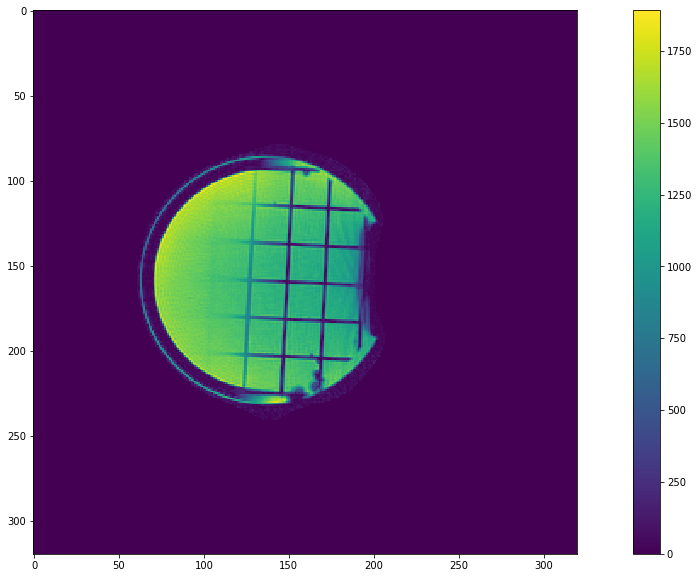

In [8]:
plt.figure(figsize=(20,10))
plt.imshow(torch.abs(I_tik.squeeze(0)).cpu().data.numpy())
plt.colorbar()